###### Name: Chun Hei Michael CHAN

# Practical Session 3 -  Atlas estimation

In shape analysis, an atlas is formed of a template shape, that captures common features of all subjects, together with a set of deformations between template and individuals. Deformations should transcribe shape variability among populations.

Here you will see deterministic atlas, the basic one. But there exists other atlas models, as bayesian atlas.


This practical session is mainly based on LDDMM algorithm.

In [1]:
import numpy as np
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt
import torch
from decimal import Decimal

tensor_type = torch.DoubleTensor

%matplotlib inline
from IPython.core.display import HTML
HTML(open("./custom_nb.css", "r").read())

# Import data

In this practical session, images will be a set of digits, to register from a template digit.
There are 20 digits, but you should test your algorithm on a sample of the set to confirm it's working.

In [2]:
dico_images = {}
for i in range(1,21):
    dico_images[i] = np.array(mpimg.imread("./Images/digits/digit_2_sample_{}.png".format(i))) 
digit_template =  np.array(mpimg.imread("./Images/digits/digit_2_mean.png")) 

# subset_digits = {1:dico_images[1],2:dico_images[2],3:dico_images[3]} 

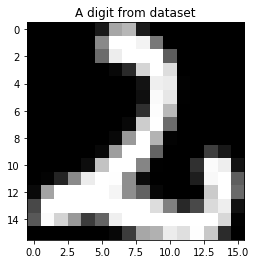

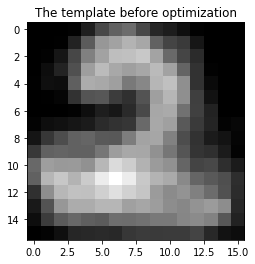

In [3]:
plt.imshow(dico_images[1],cmap='gray')
plt.title('A digit from dataset')
plt.show()

plt.imshow(digit_template,cmap='gray')
plt.title('The template before optimization')
plt.show()

# Functions

In [4]:
def _swap_colums(ar, i, j):
    aux = np.copy(ar[:, i])
    ar[:, i] = np.copy(ar[:, j])
    ar[:, j] = np.copy(aux)
    return np.copy(ar)



def interpolate_image(intensities, deformed_pixels, padding_width=1):
    '''
    This function, given original image in intensities tensor, 
    deformed pixels : coordinates of registered pixels in original image 
    returns the final registered image in deformed_intensities
    ------- 
    intensities : (nr,nc)
    deformed_pixels : (nr*nc,d)
    -------
    returns registered image in deformed_intensities, of shape (nr,nc)
    
    '''
    padding_color = 1.
    if intensities.ndim == 2:
        i,j = intensities.size()
        k = 1
        intensities_cp = intensities[...,np.newaxis]
    else :
        i,j,k = intensities.size()
        intensities_cp = intensities
        
    deformed_pixels += torch.from_numpy(np.array([float(padding_width), float(padding_width)])).view(1, 2).expand(i*j, 2).type(torch.DoubleTensor)

    padded_intensities = torch.ones((i + 2 * padding_width, j + 2 * padding_width, k)).type(torch.DoubleTensor) * padding_color
    padded_intensities[padding_width:padding_width + i, padding_width:padding_width + j] = intensities_cp

    u, v = deformed_pixels[:, 0], deformed_pixels[:, 1]

    u1 = torch.floor(u)
    v1 = torch.floor(v)

    u1 = torch.clamp(u1, 0, i - 1 + 2 * padding_width)
    v1 = torch.clamp(v1, 0, j - 1 + 2 * padding_width)
    u2 = torch.clamp(u1 + 1, 0, i - 1 + 2 * padding_width)
    v2 = torch.clamp(v1 + 1, 0, j - 1 + 2 * padding_width)

    fu = (u - u1).view(i * j, 1).expand(i*j, k)
    fv = (v - v1).view(i * j, 1).expand(i*j, k)
    gu = ((u1 + 1) - u).view(i * j, 1).expand(i*j, k)
    gv = ((v1 + 1) - v).view(i * j, 1).expand(i*j, k)

    deformed_intensities = (padded_intensities[u1.type(torch.LongTensor), v1.type(torch.LongTensor)] * gu * gv +
                            padded_intensities[u1.type(torch.LongTensor), v2.type(torch.LongTensor)] * gu * fv +
                            padded_intensities[u2.type(torch.LongTensor), v1.type(torch.LongTensor)] * fu * gv +
                            padded_intensities[u2.type(torch.LongTensor), v2.type(torch.LongTensor)] * fu * fv).view(i, j, k)
    deformed_intensities = torch.clamp(deformed_intensities, 0., 1.)

    return deformed_intensities.reshape(intensities.size())



# Functions to estimate atlas

In [5]:
def _differences(x, y):
    
    """ 
    x is of shape (n, 2)
    y is of shape (m, 2)
    --------
    returns the difference between each element of x and y in a (2,n,m) tensor
    
    """
    x_col = x.t().unsqueeze(2)  # (M,D) -> (D,M,1)
    y_lin = y.t().unsqueeze(1)  # (N,D) -> (D,1,N)
    return x_col - y_lin

def _squared_distances(x, y):
    
    """ 
    x is of shape (n, 2)
    y is of shape (m, 2)
    
    --------
    returns the squared euclidean distance between each element of x and y in a (n,m) tensor
    
    """
    
    x_norm = (x ** 2).sum(1).view(-1, 1)
    y_norm = (y ** 2).sum(1).view(1, -1)

    dist = x_norm + y_norm - 2.0 * torch.mm(x, torch.transpose(y, 0, 1))
    return dist


def gaussian_kernel(x, y, kernel_width):
    """ 
    x is of shape (n, 2)
    y is of shape (m, 2)
    kernel_width is a value
    
    --------
    returns the gaussian kernel value between each element of x and y in a (n,m) tensor
    
    """

    squared_dist = _squared_distances(x, y)
    return torch.exp(- squared_dist / kernel_width **2 )

def h_gradx(cp, alpha, kernel_width):
    
    '''
    This function computes derivative of the kernel for each couple (cp_i,alpha_i), with cp_i a control point(landmark).
    ---------
    
    cp is of shape (n_landmarks, 2)
    alpha is of shape (n_landmarks, 2)
    kernel_width is a value
    
    --------
    returns a tensor of shape (n_landmarks, 2)
    '''
    
    sq = _squared_distances(cp, cp)
    A = torch.exp(-sq / kernel_width **2)
    B = _differences(cp, cp) * A
    return (- 2 * torch.sum(alpha * (torch.matmul(B, alpha)), 2) / (kernel_width ** 2)).t()
    
    
def discretisation_step(cp, alpha, dt, kernel_width):
    
    '''
   
    This function computes a step of discretized equations for both alpha and control points on one step. 
    Compute here a displacement step  of control points an alpha, from discretized system seen in class.
    ---------
    
    cp is of shape (n_landmarks, 2)
    alpha is of shape (n_landmarks, 2)
    dt is your time step 
    kernel_width is a value
    
    --------
    
    returns resulting control point and alpha displacements in tensors of size (n_landmarks,2) both.
    
    '''

    res_cp = cp + dt * torch.matmul(gaussian_kernel(cp, cp, kernel_width), alpha)
    res_alpha = alpha - dt / 2  * h_gradx(cp, alpha, kernel_width)
    return res_cp, res_alpha



def shoot(cp, alpha, kernel_width, n_steps=10):
     
    """
    This is the trajectory of a Hamiltonian dynamic, with system seen in lecture notes. 
    Compute here trajectories of control points and alpha from t=0 to t=1.
    ------------
    cp is of shape (n_landmarks, 2)
    alpha is of shape (n_landmarks, 2)
    n_step : number of steps in your hamiltonian trajectory, use to define your time step
    kernel_width is a value
    --------
    returns traj_cp and traj_alpha trajectories of control points and alpha in lists. 
    The length of a list is equal to n_step. 
    In each element of the list, you have a tensor of size (n_landmarks,2) returned by discretisation_step() function.
    """
    
    
    traj_cp, traj_alpha = [], []
    traj_cp.append(cp)
    traj_alpha.append(alpha)
    dt = 1. / float(n_steps-1)
    
    for _ in range(n_steps-1):
        new_cp, new_alpha = discretisation_step(traj_cp[-1], traj_alpha[-1], dt, kernel_width)
        traj_cp.append(new_cp)
        traj_alpha.append(new_alpha)
        
    return traj_cp, traj_alpha

In [6]:
def register_points(traj_cp, traj_alpha, y, kernel_width):
    """
    This is the application of the computed trajectories on a set of points (landmarks or new points).
    ------------
    
    traj_cp is the list containing the trajectory of your landmarks 
    traj_alpha is is the list containing the trajectory of your alpha 
    y : points you want to register (landmarks or other points), size (n,2)
    kernel_width is a value
    
    --------
    
    returns traj_y,  the trajectory of points y, in a list of length n_step. 
    In each element of the list, you should have an array of dimension (n,2) (same dimensions as y)
    
    """
    # We now flow the points
    traj_y = [y]
    n_steps = len(traj_cp) - 1
    dt = 1. / float(n_steps)
    
    for i in range(len(traj_cp)-1):
        new_y = traj_y[-1] + dt * torch.matmul(gaussian_kernel(traj_y[-1], traj_cp[i], kernel_width), traj_alpha[i])
        traj_y.append(new_y)
    
    return traj_y

In [7]:
def register_image(traj_cp, traj_alpha, image, kernel_width):
    """
    This is the application of the computed trajectories on an image, by computation of inversed phi_1.
    ------------
    traj_cp is the list containing the trajectory of your landmarks 
    traj_alpha is the list containing the trajectory of your alpha 
    image : image to register, of size (nr,nc)
    kernel_width is a value
    --------
    returns the registered image, of same dimensions as image, (nr,nc)
    
    """
    
    if image.ndim==2:
        i,j = image.shape
        k = 1
    else :
        i,j,k = image.shape
        
    points = np.array(np.meshgrid(range(i), range(j)))
    points = np.swapaxes(points, 0, 2).reshape(i * j, 2) 
    points = torch.from_numpy(points).type(tensor_type)
    traj_cp_inverse = traj_cp[::-1]
    traj_alpha_inverse = [-1 * elt for elt in traj_alpha[::-1]]
    deformed_points = register_points(traj_cp_inverse, traj_alpha_inverse, points, kernel_width)[-1]
    
    return interpolate_image(image, deformed_points)

**Below you have to compute attachment and regularity between template and each subject (image).**\
With these values then, you compute the total attachment and total regularity.
At the end of the function, the total cost function is already written.\
Data attachment is how well the collection of objects is fitted by the deformation of the template.\
Regularity acts as a regularizer by penalizing the kinetic energy of the deformations.

In [8]:
def compute_attachment_regularity_gradient(cp,momenta,template_data,subjects,kernel_width,gamma):
    '''
    TO DO
    ATTENTION : you only use torch tensors here, no numpy objects
    ----------
    This function compute attachments and regularities in order to compute the loss and optimize momenta, template with gradient descent.
    In order to do this, you have to deform control points and template as with LDDMM, for each image/subject.
    Then compute attachment and regularity for each deformed template and points, and finally the total attachment and total regularity.
    cp : tensor (n_landmarks,2)
    momenta : tensor (n_landmarks,2,n_images)
    template_data : tensor (nr,nc)
    subjects : tensor (nr,nc,n_images)
    kernel_width and gamma : parameters - values
    ----- 
    returns 4 objects :
    attachement is a tensor with only one value inside, ex. tensor(10.0)
    regularity is a tensor with only one value inside
    deformed template according to each subject : numpy array (nr,nc,n_images) 
    deformed control points according to each subject : numpy array (n_landmarks,2,n_images)
    '''
    
    attachment, regularity = 0.,0.
    deformed_template_list, deformed_points_list = [], []
    #we loop over all the alphas of each image/subject to deform our template
    #### Compute an estimation of control points and alpha trajectories
    for idx in range(momenta.shape[2]):
        alpha = momenta[:,:,idx]
        traj_cp, traj_alpha = shoot(cp, alpha, kernel_width, n_steps=10)
        
        def_pts = register_points(traj_cp, traj_alpha, cp, kernel_width)[-1]
        img = register_image(traj_cp, traj_alpha, template_data,kernel_width)
        
        deformed_points_list.append(def_pts)
        deformed_template_list.append(img)
        
        attachment += torch.sum((img-subjects[:,:,idx])**2)
        regularity += gamma * torch.sum(torch.mm(alpha.T,torch.mm(gaussian_kernel(cp,cp,kernel_width), alpha)))
        
    #transform the lists into the correct shape tensors
    deformed_points = deformed_points_list[0]
    deformed_template = deformed_template_list[0]
    
    deformed_points = torch.reshape(deformed_points,(deformed_points.shape[0],deformed_points.shape[1],1))
    deformed_template = torch.reshape(deformed_template,(deformed_template.shape[0],deformed_template.shape[1],1))
    
    for idx in range(1,momenta.shape[2]):
        tmp1 = torch.reshape(deformed_points_list[idx],(deformed_points.shape[0],deformed_points.shape[1],1))
        deformed_points = torch.cat((deformed_points,tmp1),axis=-1)
        
        tmp2 = torch.reshape(deformed_template_list[idx],(deformed_template.shape[0],deformed_template.shape[1],1))
        deformed_template = torch.cat((deformed_template,tmp2),axis=-1)
    
    ### here is computed the total loss and  gradient with torch.backward()
    total = attachment + regularity
    total.backward()

    return attachment.detach(),regularity.detach(),deformed_template.detach(),deformed_points.detach()

In [9]:
def atlas_learn_template(dico_images,niter,kernel_width,gamma,eps,template=None,landmarks=None):
    
    '''
    This is the principal function, which computes gradient descent to minimize cost function,
    find optimal trajectories for control points, alpha and deformed template
    Take a dictionary with images, niter number of iterations, kernel_width and gamma parameters, eps for step size
    template and landmarks are optionals.
    -------
    returns 
    cp : deformation of  control points to match with each subject : numpy array (n_landmarks,2,n_images)
    alpha : optimized momenta,  numpy array (n_landmarks,2,n_images)
    template_data : the optimized template, numpy array (nr,nc) 
    deformed_template : deformation of template according to each image,  numpy array (nr,nc,n_images)

    '''

  
    ## Convert from dico of images to 3 dimensional array (nr,nc,n_images)
    
    Images = dico_images[1]
    for key, value in dico_images.items():
        if key==2:
            Images = np.stack((Images,value),axis=-1)   
        elif key !=1 :
            Images = np.concatenate((Images,value[...,np.newaxis]),axis=-1)   

    Images_base = torch.from_numpy(Images.copy()).type(tensor_type)
    
    
    ### Convert template, if given, to a tensor (nx,ny)
    ### If no template is provided, take first image of set, but it's not the optimal solution
    if template is None :
        template_data = torch.from_numpy(Images[...,0].copy()).type(tensor_type)  
    else :
        template_data = torch.from_numpy(template).type(tensor_type)
        
    #### Initialize control points and momenta for template
    #### Here, with digits database, no control points are provided, 
    #### So we build a regular grid with interval equals to kernel_width.
    #### You can plot control points to see where they are exactly.
    #### cp tensor is of  shape (n_landmarks,2) with y-axis coordinates in first column and x-axis coordinates in second column
    if landmarks is not None :
        cp = torch.from_numpy(landmarks1).type(tensor_type)
    else :
        cp = np.array(np.meshgrid(np.arange(0,template.shape[0]-2,kernel_width), np.arange(0,template.shape[1]-2,kernel_width)))
        cp = np.swapaxes(cp, 0, 2).reshape(-1, 2) 
        cp = torch.from_numpy(cp).type(tensor_type)
        

    
    ##### Plot template at the beginning and first original digits
    
    plt.figure()
    plt.subplot(1,5,1)
    plt.imshow(template_data.detach().numpy(),cmap='gray')
    plt.subplot(1,5,2)
    plt.imshow(np.clip(Images[...,0],0,1),cmap='gray')
    plt.subplot(1,5,3)
    plt.imshow(np.clip(Images[...,1],0,1),cmap='gray')
    plt.subplot(1,5,4)
    plt.imshow(np.clip(Images[...,2],0,1),cmap='gray')
    plt.subplot(1,5,5)
    plt.imshow(np.clip(Images[...,3],0,1),cmap='gray')
    plt.title('Template at the beginning and first four digits')
    plt.show()
      
    #######################    
    #### Iterations    
            
    number_of_subjects = Images_base.size(-1)
    alpha = torch.zeros((cp.size(0),cp.size(1),number_of_subjects)).type(tensor_type)
    alpha.requires_grad_(True)
    template_data.requires_grad_(True)
    
    
    for it in range(niter):
        
        current_attachment, current_regularity,deformed_template,deformed_points = compute_attachment_regularity_gradient(cp,alpha,template_data,Images_base,kernel_width,gamma)
  
        gradient = {}
        gradient['alpha'] = alpha.grad.detach()
        gradient['template_data'] = template_data.grad.detach()

        eps_mom = eps/np.sqrt(np.sum(gradient['alpha'].numpy() ** 2))
        eps_template = eps/np.sqrt(np.sum(gradient['template_data'].numpy() ** 2)+10**-5)
        
        with torch.no_grad():
            alpha -=   alpha.grad * eps_mom
            template_data -=   template_data.grad * eps_template
            
        alpha.grad.zero_()
        template_data.grad.zero_()
        
                                                                                
       
  
        attach_val = current_attachment.numpy()
        regul_val = current_regularity.numpy()

        if it % 20 == 0:
            print('------------------------------------- Iteration: ' + str(it)  + ' -------------------------------------')
            print('>> [ attachment = %.5E ; regularity = %.5E ]' %
              (Decimal(str(attach_val)),
               Decimal(str(regul_val))))

   
            ##### Plot template and deformed template according to first digits

            plt.figure()
            plt.subplot(1,5,1)
            plt.imshow(np.clip(template_data.detach().numpy(),0,1),cmap='gray')
            plt.title('Template')
            plt.subplot(1,5,2)
            plt.imshow(np.clip(deformed_template.detach().numpy()[...,0],0,1),cmap='gray')
            plt.subplot(1,5,3)
            plt.imshow(np.clip(deformed_template.detach().numpy()[...,1],0,1),cmap='gray')
            plt.subplot(1,5,4)
            plt.imshow(np.clip(deformed_template.detach().numpy()[...,2],0,1),cmap='gray')
            plt.subplot(1,5,5)
            plt.imshow(np.clip(deformed_template.detach().numpy()[...,3],0,1),cmap='gray')
            plt.show()
    

    
    return cp.detach().numpy(),alpha.detach().numpy(),np.clip(template_data.detach().numpy(),0,1),deformed_template.detach().numpy()

# Execution of the algorithm

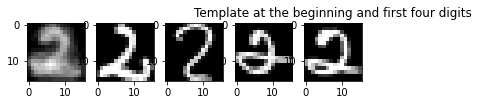

------------------------------------- Iteration: 0 -------------------------------------
>> [ attachment = 5.51231E+02 ; regularity = 0.00000E+00 ]


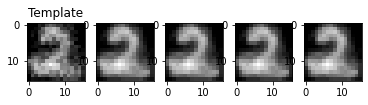

------------------------------------- Iteration: 20 -------------------------------------
>> [ attachment = 4.77377E+02 ; regularity = 1.39251E+01 ]


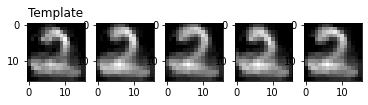

------------------------------------- Iteration: 40 -------------------------------------
>> [ attachment = 3.92425E+02 ; regularity = 1.58783E+01 ]


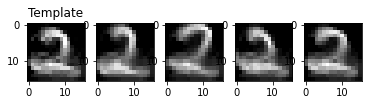

------------------------------------- Iteration: 60 -------------------------------------
>> [ attachment = 3.41014E+02 ; regularity = 1.67610E+01 ]


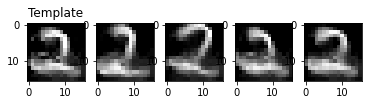

------------------------------------- Iteration: 80 -------------------------------------
>> [ attachment = 3.02951E+02 ; regularity = 1.66663E+01 ]


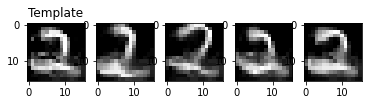

------------------------------------- Iteration: 100 -------------------------------------
>> [ attachment = 2.74213E+02 ; regularity = 1.68668E+01 ]


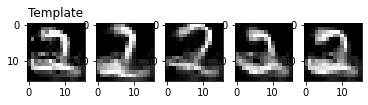

------------------------------------- Iteration: 120 -------------------------------------
>> [ attachment = 2.57205E+02 ; regularity = 1.56397E+01 ]


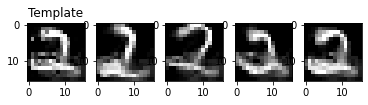

------------------------------------- Iteration: 140 -------------------------------------
>> [ attachment = 2.45544E+02 ; regularity = 1.49484E+01 ]


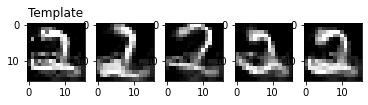

------------------------------------- Iteration: 160 -------------------------------------
>> [ attachment = 2.35852E+02 ; regularity = 1.33325E+01 ]


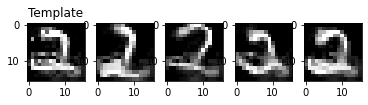

------------------------------------- Iteration: 180 -------------------------------------
>> [ attachment = 2.23639E+02 ; regularity = 1.19453E+01 ]


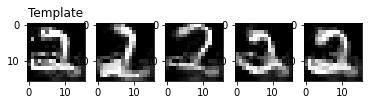

In [72]:
eps = 1 ## Don't play with this one

#### Play with these parameters

kernel_width = 2
niter = 200
gamma = 10


## Execution of the algorithm
control_points, momenta,optim_template,deformed_digits = atlas_learn_template(dico_images,niter,kernel_width,gamma,eps,template=digit_template,landmarks=None)


## Obtained template

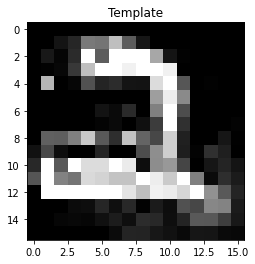

In [73]:
plt.figure()
plt.imshow(optim_template,cmap='gray')
plt.title("Template")
plt.show()

## Deformed template for each digit

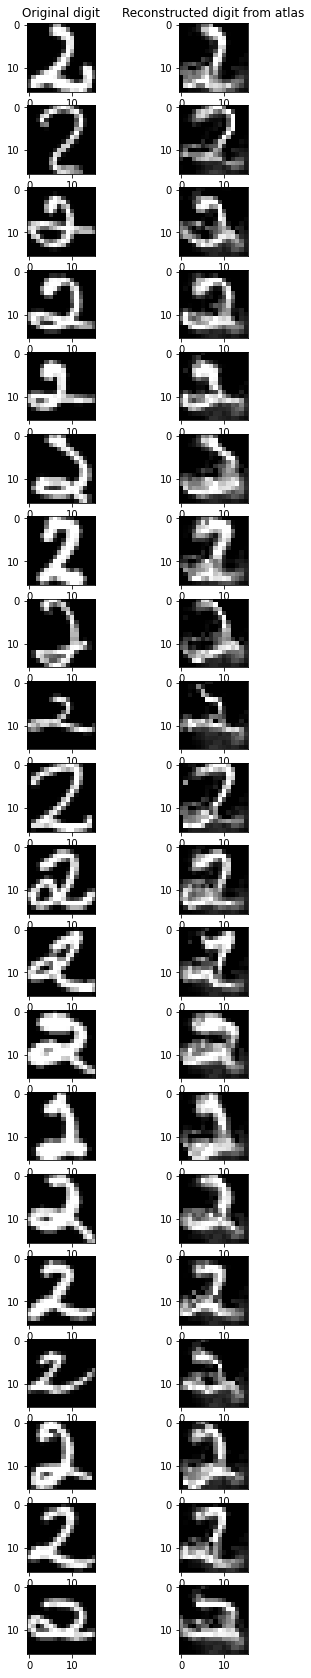

In [74]:
n_subjects = deformed_digits.shape[-1]
plt.figure(figsize=(5,30))
number_image = 1

for i in dico_images.keys():
    plt.subplot(n_subjects,2,number_image)
    plt.imshow(dico_images[i],cmap='gray')
    if i==1:
        plt.title('Original digit')

    plt.subplot(n_subjects,2,number_image+1)
    plt.imshow(deformed_digits[...,i-1],cmap='gray')
    if i==1:
        plt.title('Reconstructed digit from atlas')

    number_image += 2
plt.show()

**Play with parameters. What are their effects on the atlas estimation ?**

##### Answer: 
The effects on the template data are, when we modify the parameters in the following way,:
- small $\sigma$ (kernel_width): (e.g 1) we see artifact being created, noises in the reconstructed digit from atlas but also a very heavily modified template data that does not look like a $2$. However reconstructed digits a very much close to the correct dico_image, since details of the digits are captured well
- large $\sigma$ (kernel_width): (e.g 10) we see that the attachement takes longer time to converge, and the attachement starts at very high value. We have very global movements, which might explain why preciser shapes of the dico_images are not reproducible.
- small $\gamma$: (e.g 0) we would expect a rigid fitting, but then it is in this situation working fine. A small $\gamma$ allows for bigger momentum that might cause this rigidity, but in our case again, it seems fine even in the reconstructed digits.
- large $\gamma$: (e.g 10) We notice that the attachement value is high, since the regularity coefficient is high. In terms of picture, we do see dispersed white dots. We could potentially give as explanation that since, the template_data started blurry, some neighbourhood were not able to be mapped correctly due to small momentum allowed and thus leaving these blurs there, in the reconstructed images.
- small/large number of iteration: from my own perspective the change in the optimized template is not noticeable (obviously when the number of iteration is over a "very small" threshold, like 10 iteration.). While not noticeable, we do have a huge improvement in attachement which plateaus at around 500 iterations. The regularization number seem to vary in a random way.

# Execution on noised images

**Add gaussian noise to the input images.**\
In order to do this, directly modify images in dictionary `dico_images`. Or create a new dictionary with noised images.

**Execute again the atlas estimation algorithm in next cells**


**Q: What happens ?** 

##### Answer:
From the small test we did below we notice that when adding noises to the population, the template data is itself also very noisy even when optimized regardless of the parameters that we started with. We notice a very much more smoother picture on the original test compared to the noisy test. The attachement is a lot higher when it is done converging. We can interpret it this way: if we have a global (large kernel_width) capturing, then the convergence of the noisy images would most likely be difficult, while having a local capture might highly change the optimum template_data.

In [54]:
#Adding gaussian noise onto dico_images
#As we assumed in the lecture, our Gaussian Noise will be Normal component-wise
mean = 0
var = 0.15
add_noise = lambda x: np.array([[x[i,j]+np.random.normal(mean,var) for j in range(x.shape[0])] for i in range(x.shape[0])])

In [55]:
new_dico_images = dict()
for idx in dico_images.keys():
    new_dico_images[idx] = add_noise(dico_images[idx])

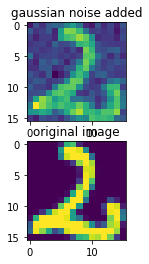

In [56]:
plt.figure(1)
plt.subplot(211)
plt.imshow(new_dico_images[1])
plt.title('gaussian noise added')
plt.subplot(212)
plt.title('original image')
plt.imshow(dico_images[1])

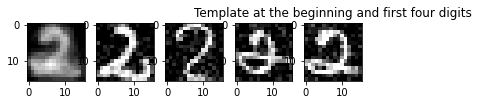

------------------------------------- Iteration: 0 -------------------------------------
>> [ attachment = 6.60431E+02 ; regularity = 0.00000E+00 ]


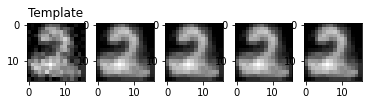

------------------------------------- Iteration: 20 -------------------------------------
>> [ attachment = 3.07605E+02 ; regularity = 4.68976E+00 ]


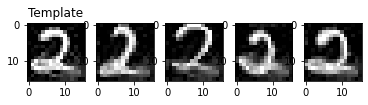

------------------------------------- Iteration: 40 -------------------------------------
>> [ attachment = 2.37301E+02 ; regularity = 6.76180E+00 ]


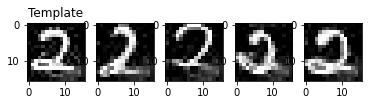

------------------------------------- Iteration: 60 -------------------------------------
>> [ attachment = 2.18459E+02 ; regularity = 7.70703E+00 ]


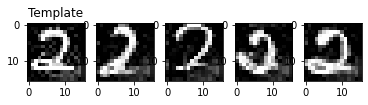

------------------------------------- Iteration: 80 -------------------------------------
>> [ attachment = 2.08179E+02 ; regularity = 8.22372E+00 ]


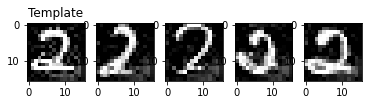

------------------------------------- Iteration: 100 -------------------------------------
>> [ attachment = 2.01898E+02 ; regularity = 8.61829E+00 ]


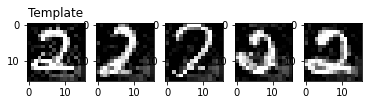

------------------------------------- Iteration: 120 -------------------------------------
>> [ attachment = 1.97260E+02 ; regularity = 8.64809E+00 ]


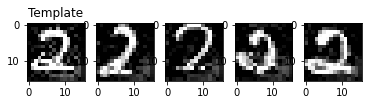

------------------------------------- Iteration: 140 -------------------------------------
>> [ attachment = 1.89209E+02 ; regularity = 8.90330E+00 ]


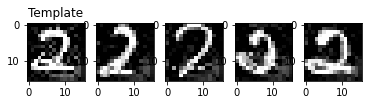

------------------------------------- Iteration: 160 -------------------------------------
>> [ attachment = 1.89749E+02 ; regularity = 8.90701E+00 ]


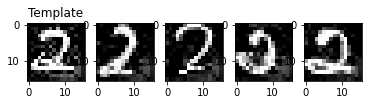

------------------------------------- Iteration: 180 -------------------------------------
>> [ attachment = 1.88001E+02 ; regularity = 9.04431E+00 ]


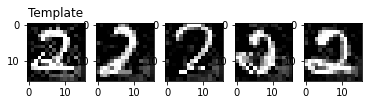

------------------------------------- Iteration: 200 -------------------------------------
>> [ attachment = 1.81994E+02 ; regularity = 9.16892E+00 ]


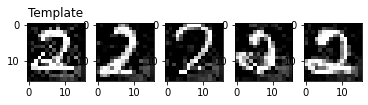

------------------------------------- Iteration: 220 -------------------------------------
>> [ attachment = 1.83315E+02 ; regularity = 9.25555E+00 ]


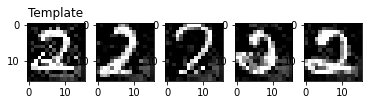

------------------------------------- Iteration: 240 -------------------------------------
>> [ attachment = 1.77878E+02 ; regularity = 9.44607E+00 ]


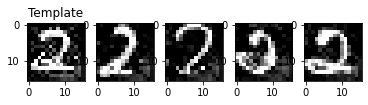

------------------------------------- Iteration: 260 -------------------------------------
>> [ attachment = 1.77838E+02 ; regularity = 9.47466E+00 ]


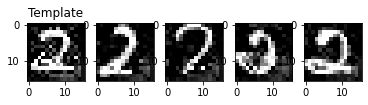

------------------------------------- Iteration: 280 -------------------------------------
>> [ attachment = 1.79697E+02 ; regularity = 9.51696E+00 ]


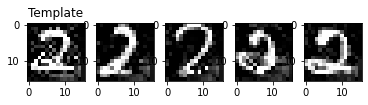

------------------------------------- Iteration: 300 -------------------------------------
>> [ attachment = 1.83941E+02 ; regularity = 9.76603E+00 ]


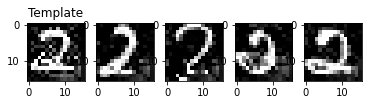

------------------------------------- Iteration: 320 -------------------------------------
>> [ attachment = 1.77539E+02 ; regularity = 9.52544E+00 ]


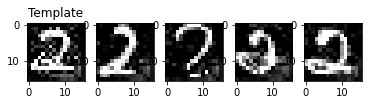

------------------------------------- Iteration: 340 -------------------------------------
>> [ attachment = 1.75260E+02 ; regularity = 9.57361E+00 ]


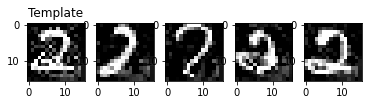

------------------------------------- Iteration: 360 -------------------------------------
>> [ attachment = 1.72448E+02 ; regularity = 9.61789E+00 ]


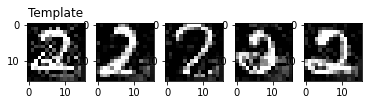

------------------------------------- Iteration: 380 -------------------------------------
>> [ attachment = 1.68960E+02 ; regularity = 9.61270E+00 ]


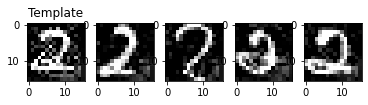

------------------------------------- Iteration: 400 -------------------------------------
>> [ attachment = 1.72568E+02 ; regularity = 9.54956E+00 ]


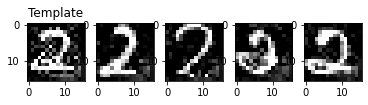

------------------------------------- Iteration: 420 -------------------------------------
>> [ attachment = 1.71226E+02 ; regularity = 1.00026E+01 ]


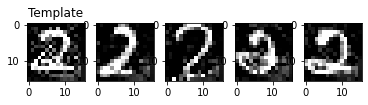

------------------------------------- Iteration: 440 -------------------------------------
>> [ attachment = 1.76607E+02 ; regularity = 1.00585E+01 ]


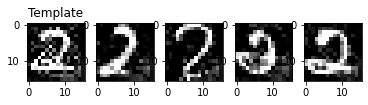

------------------------------------- Iteration: 460 -------------------------------------
>> [ attachment = 1.65510E+02 ; regularity = 1.00443E+01 ]


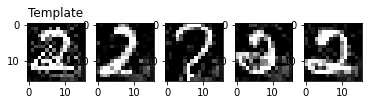

------------------------------------- Iteration: 480 -------------------------------------
>> [ attachment = 1.66745E+02 ; regularity = 1.00028E+01 ]


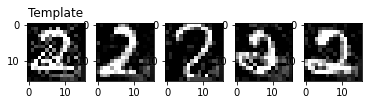

In [57]:
#for noise adding training
eps = 1 ## Don't play with this one

#### Play with these parameters

kernel_width = 2
niter = 500
gamma = 0.01


## Execution of the algorithm
control_points, momenta,optim_template,deformed_digits = atlas_learn_template(new_dico_images,niter,kernel_width,gamma,eps,template=digit_template,landmarks=None)

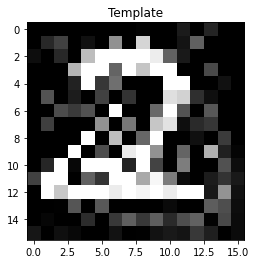

In [58]:
plt.figure()
plt.imshow(optim_template,cmap='gray')
plt.title("Template")
plt.show()